In [11]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="ticks", palette="mako")

In [12]:
# Reading short imputed master dataframe
master_df = pd.read_csv("data/2016_2021_master_df_short_imputed.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


(228056, 5)


## Imputation of short sequences (2h, 6h]
* Short sequences with 3 to 6 subsequent data points missing
* FFT
* LSTM

In [13]:
# Experimentation subsets
# Vancouver Clark Drive station
subsets_clark = {}
# 1 Month no major anomaly
subsets_clark["Vancouver_Clark_Drive_PM25_2-2016"] = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"].loc[
    datetime(2016, 2, 1):datetime(2016, 3, 1), ["PM 2.5"]]
# 3 Months with major anomaly
subsets_clark["Vancouver_Clark_Drive_PM25_7-2018_to_9-2018"] = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"].loc[
    datetime(2018, 7, 1):datetime(2018, 10, 1), ["PM 2.5"]]
# 12 Months with major anomaly
subsets_clark["Vancouver_Clark_Drive_2020"] = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"].loc[
    datetime(2020, 1, 1):datetime(2021, 1, 1), ["PM 2.5"]]
# Complete series
subsets_clark["Vancouver_Clark_Drive_PM25"] = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"][["PM 2.5"]]

# North Vancouver Mahon Park station
subsets_mahon = {}
# 1 Month no major anomaly
subsets_mahon["North_Vancouver_Mahon_Park_PM25_2-2017"] = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"].loc[
    datetime(2017, 2, 1):datetime(2017, 3, 1), ["PM 2.5"]]
# 3 Months with major anomaly
subsets_mahon["North_Vancouver_Mahon_Park_PM25_7-2020_to_9-2020"] = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"].loc[
    datetime(2020, 7, 1):datetime(2020, 10, 1), ["PM 2.5"]]
# 12 Months with major anomaly
subsets_mahon["North_Vancouver_Mahon_Park_PM25_2021"] = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"].loc[
    datetime(2021, 1, 1):datetime(2022, 1, 1), ["PM 2.5"]]
# Complete series
subsets_mahon["North_Vancouver_Mahon_Park_PM25"] = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"][["PM 2.5"]]

In [14]:
from darts import TimeSeries
from darts.models import FFT
from darts.metrics import mae, rmse

# Darts timeseries64
for subset in subsets_clark:
    subsets_clark[subset] = TimeSeries.from_dataframe(subsets_clark[subset])

for subset in subsets_mahon:
    subsets_mahon[subset] = TimeSeries.from_dataframe(subsets_mahon[subset])

In [21]:
# Auxiliar plotting function
def dart_plot(train, val, pred=None):
    plt.figure(figsize=(12, 2.5))
    train.plot(label="training")
    val.plot(label="validation", linewidth=1)
    if pred:
        pred.plot(label="predict", linewidth=1.5, color = "darkorange")
        plt.title(f"MAE: {mae(pred, val):.3f} | RMSE: {rmse(pred, val):.3f}", fontsize=10)
        plt.suptitle(f"{subset}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11, y=1.04)
    else:
        plt.title(f"{subset}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11)
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    sns.despine()
    plt.show()

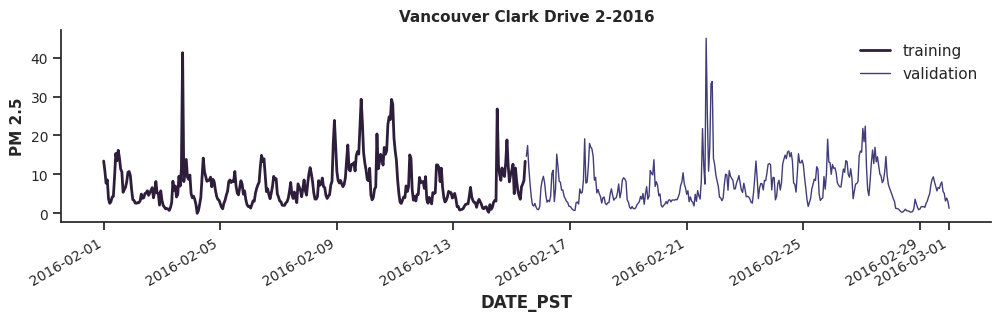

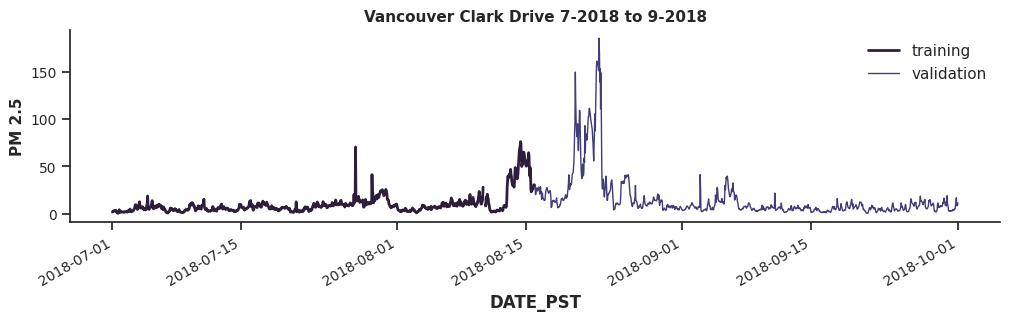

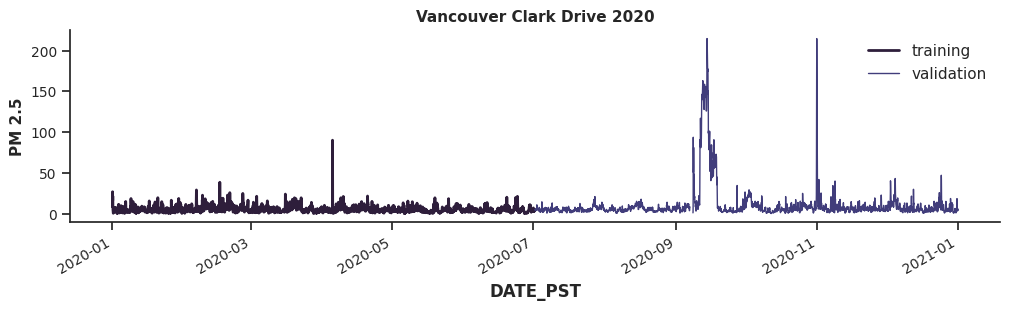

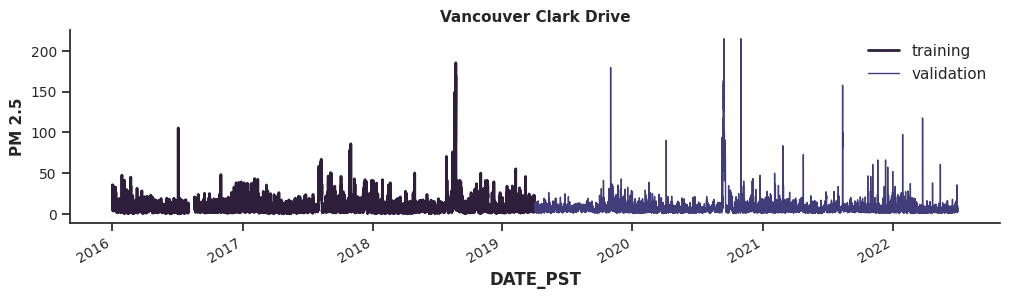

In [22]:
# Training and Validation sets Clark Drive
for subset in subsets_clark:
    series = subsets_clark[subset]
    train, val = series.split_before(0.5)

    # Darts training and validation plot
    dart_plot(train, val)

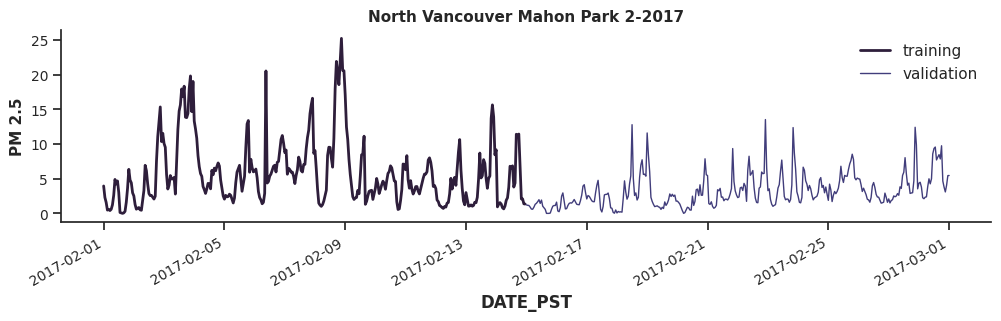

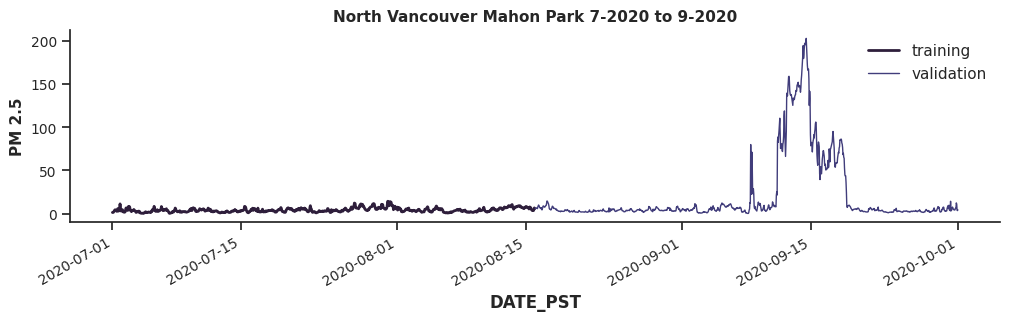

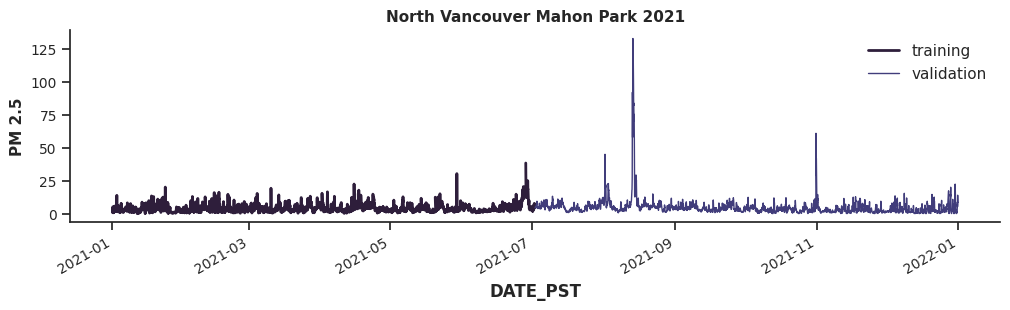

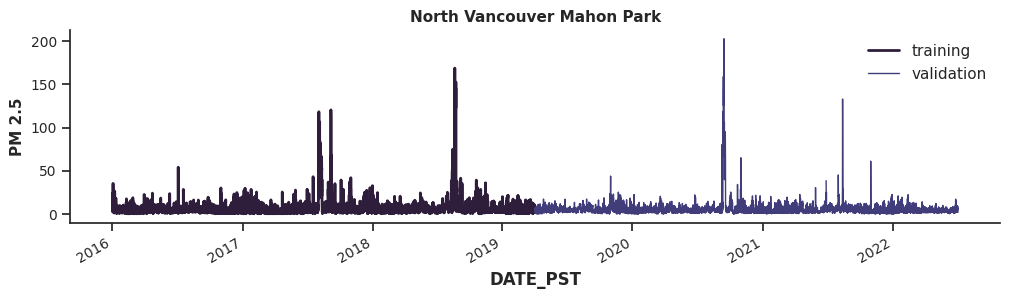

In [23]:
# Training and Validation sets Mahon Park
for subset in subsets_mahon:
    series = subsets_mahon[subset]
    train, val = series.split_before(0.5)

    # Darts training and validation plot
    dart_plot(train, val)

## Fast Fourier Transform
* Base model without amplitude filtering
* Base model filtering low-amplitude waves

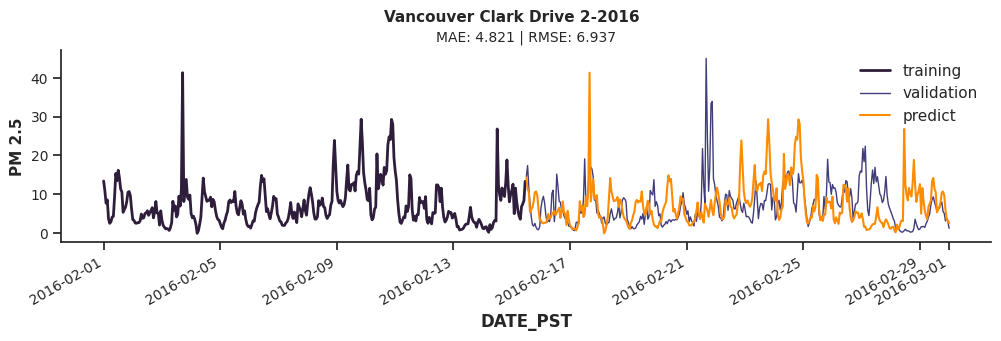

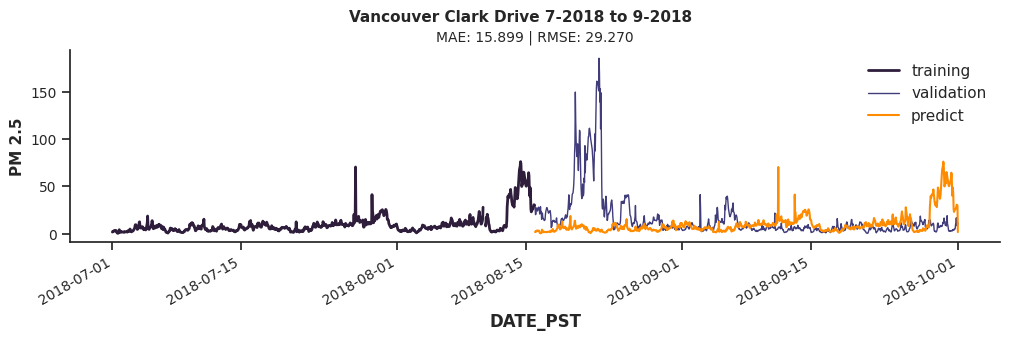

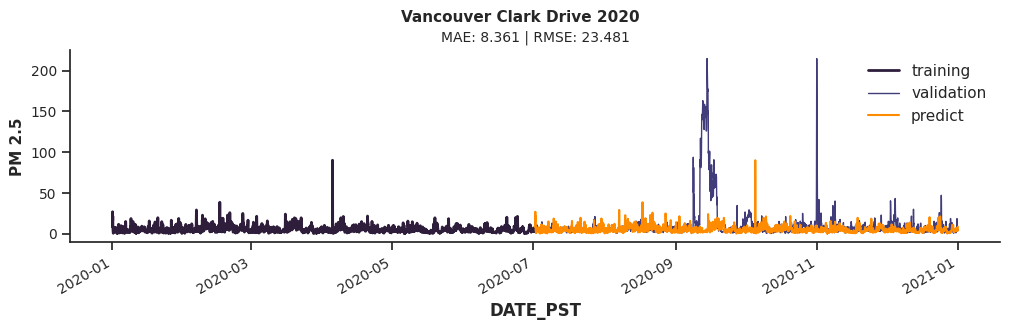

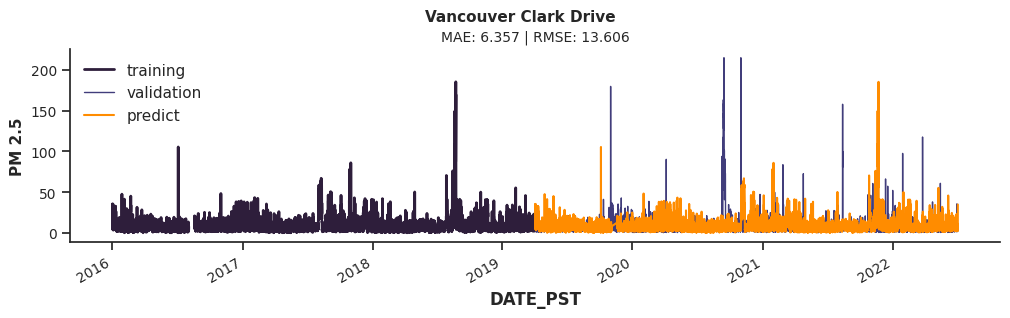

In [24]:
# Fast Fourier Transform without amplitude filtering
fft_model = FFT(nr_freqs_to_keep=None)

for subset in subsets_clark:
    # Train test split
    series = subsets_clark[subset]
    train, val = series.split_before(0.5)

    fft_model.fit(train)
    pred_val = fft_model.predict(len(val))

    dart_plot(train, val, pred_val)

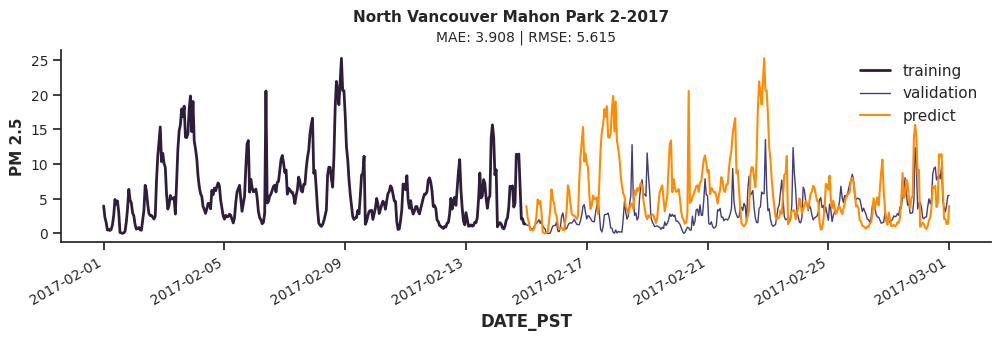

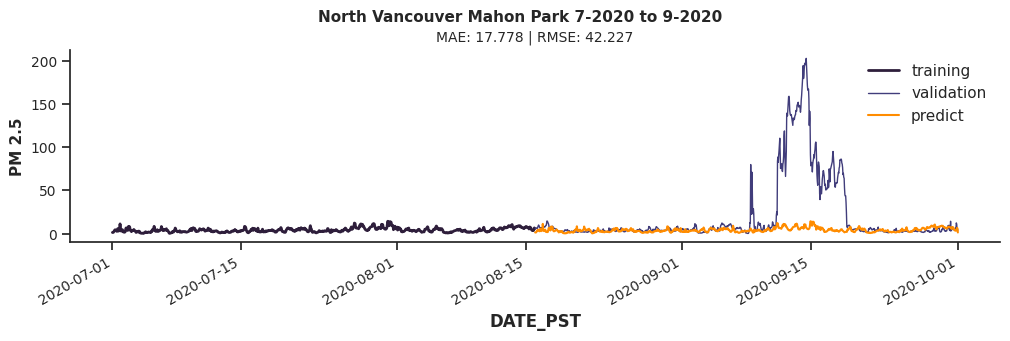

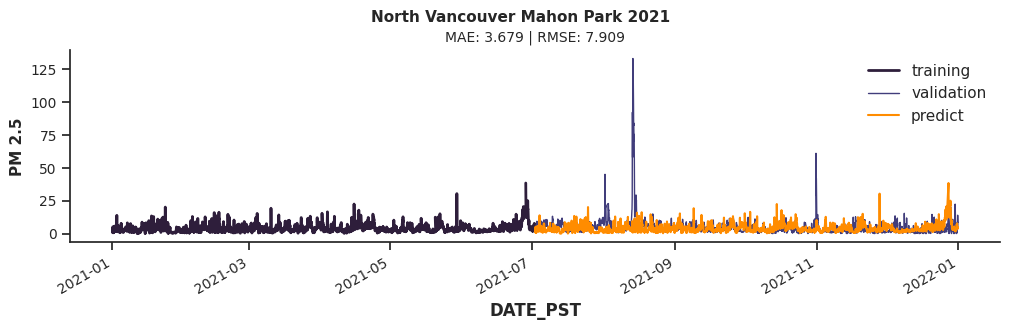

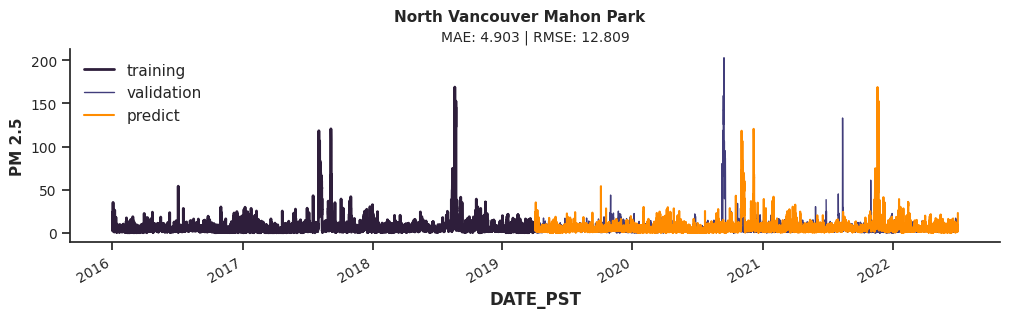

In [25]:
# Fast Fourier Transform without amplitude filtering
fft_model = FFT(nr_freqs_to_keep=None)

for subset in subsets_mahon:
    # Train test split
    series = subsets_mahon[subset]
    train, val = series.split_before(0.5)

    fft_model.fit(train)
    pred_val = fft_model.predict(len(val))

    dart_plot(train, val, pred_val)

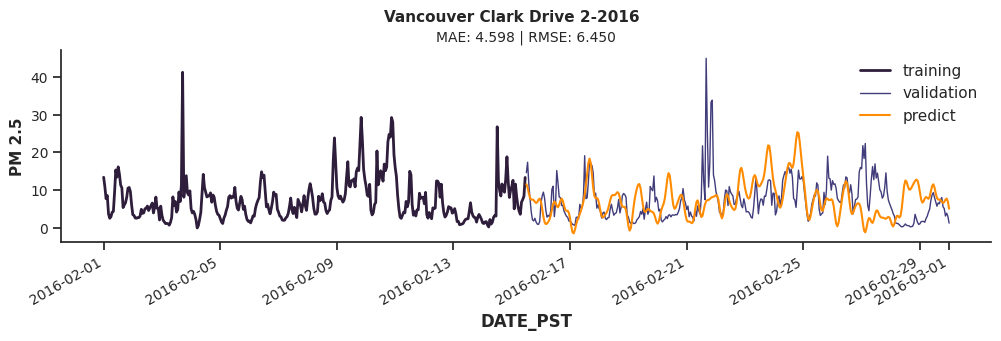

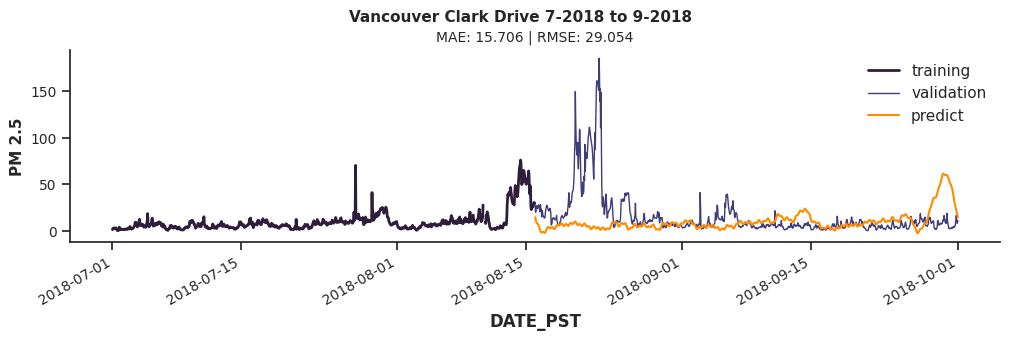

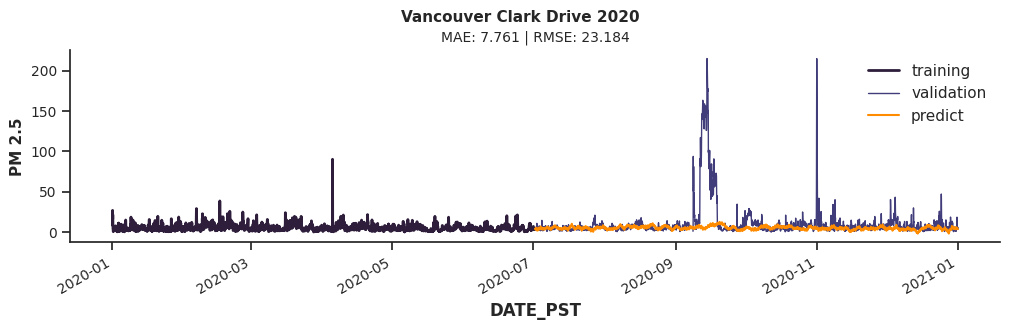

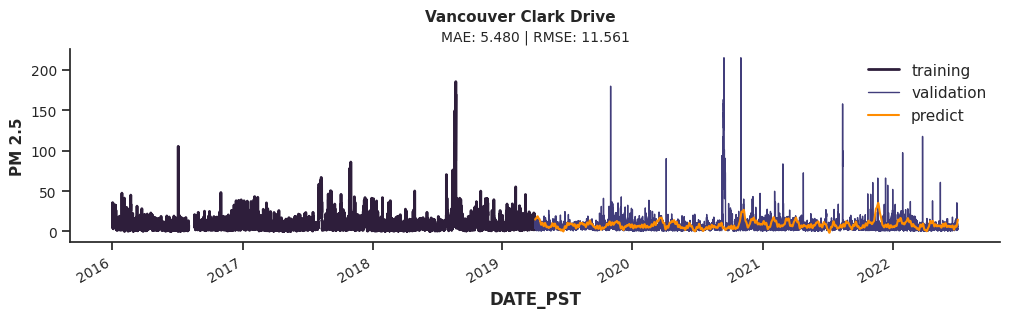

In [26]:
# Fast Fourier Transform filtering low-amplitude waves
fft_model = FFT(nr_freqs_to_keep=50)

for subset in subsets_clark:
    # Train test split
    series = subsets_clark[subset]
    train, val = series.split_before(0.5)

    fft_model.fit(train)
    pred_val = fft_model.predict(len(val))

    dart_plot(train, val, pred_val)

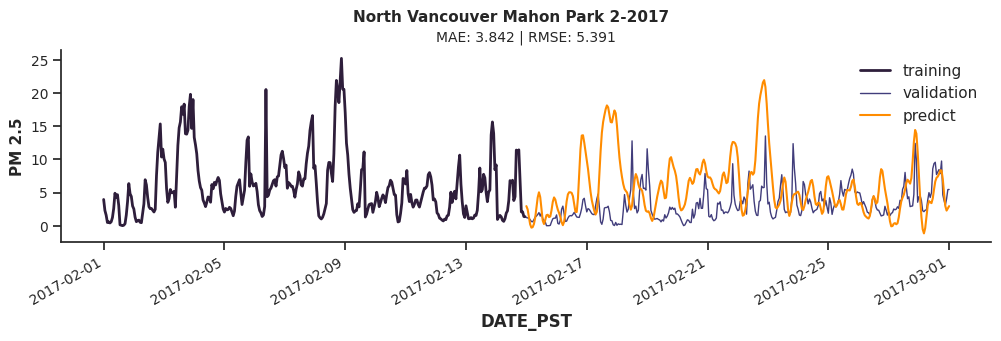

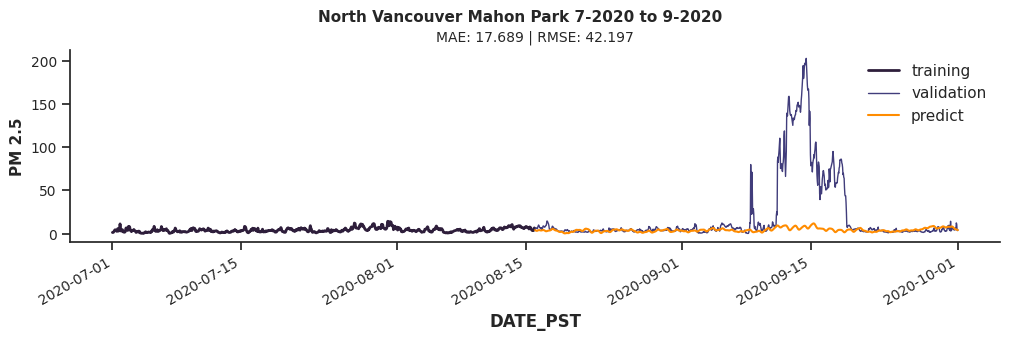

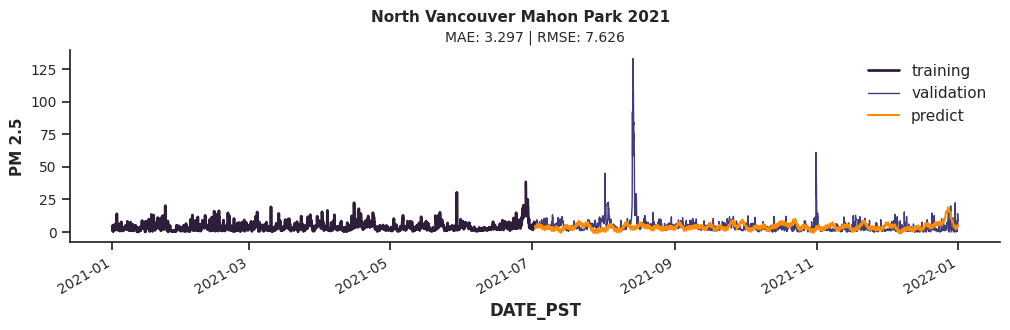

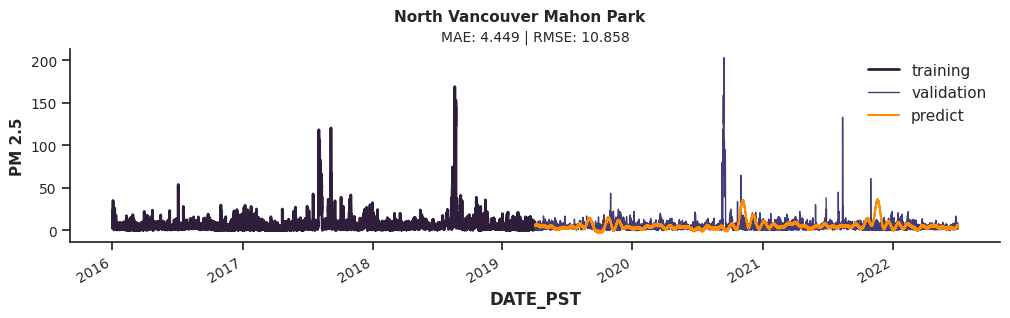

In [34]:
# Fast Fourier Transform filtering low-amplitude waves
fft_model = FFT(nr_freqs_to_keep=50)

for subset in subsets_mahon:
    # Train test split
    series = subsets_mahon[subset]
    train, val = series.split_before(0.5)

    fft_model.fit(train)
    pred_val = fft_model.predict(len(val))

    dart_plot(train, val, pred_val)

## LSTM
* Univariate LSTM
* LSTM with dateparts covariates

In [ ]:
from darts.models import RNNModel, BlockRNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from sklearn.preprocessing import MinMaxScaler

